In [1]:
from os import listdir
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.sequence import TimeseriesGenerator
from PIL import Image
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import random

C:\Users\Rock_\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def load_photos(directory):
    images = []
    labels_speed = []
    labels_dir = []
    time_stamps = []
    dir_list = listdir(directory)
    for name in dir_list:
        filename = directory + '/' + name
        # load an image from file
        image = load_img(filename, target_size=(96, 160))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # get image id + labels
        time_stamp = float(name.split('_')[0])
        value_dir = float(name.split('_')[1])
        value_speed = float(name.split('_')[2].split(".")[0])
        labels_dir.append(value_dir)
        labels_speed.append(value_speed)
        time_stamps.append(time_stamp)
        images.append(image)
    return images, time_stamps, labels_speed, labels_dir

In [3]:
dataset = "Auto"
window_size = 3


In [4]:
# load images from both train and test groups
directory = '../../../../'+dataset
images, time_stamps, labels_speed, labels_dir = load_photos(directory)
nb_images = len(images)
print('Loaded Images and labels for training: %d' % nb_images)

Loaded Images and labels for training: 2430


In [5]:
#Normalise images
images = np.array(images)
images /= 255.0

In [6]:
sequences = []
i = 0
for i, image in enumerate(images):
    if i + window_size <= len(images): 
        sequence = images[i:i+window_size]
        sequences.append(sequence)

In [7]:
#convert datas to dummyvalues
labels_speed = np.array(pd.get_dummies(labels_speed))
labels_dir = np.array(pd.get_dummies(labels_dir))

In [8]:
labels_speed = labels_speed[window_size-1:]
labels_dir = labels_dir[window_size-1:]

(1538151356.46,
 array([1, 0], dtype=uint8),
 array([1, 0, 0, 0, 0], dtype=uint8),
 <matplotlib.image.AxesImage at 0x227ed862828>)

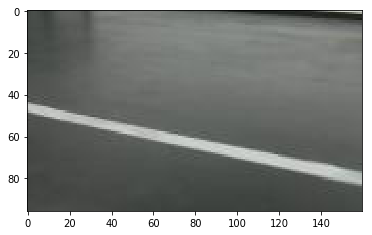

In [9]:
time_stamps[42], labels_speed[42], labels_dir[42], plt.imshow(images[42])

In [10]:
len(sequences), len(labels_dir), len(labels_speed)

(2428, 2428, 2428)

In [11]:
from keras.models import Model, Sequential
from keras.layers import *
import keras.backend as K
import keras.optimizers as Optimizers
import keras.callbacks

In [12]:
#from keras.models import load_model
#model = load_model("model_bigrace_original_5.h5")

In [24]:
'''
Model from PatateV2
'''

K.clear_session()
############################################################# 

img_in = Input(shape=(window_size, 96, 160, 3), batch_shape=(4, window_size, 96, 160, 3), name='img_in')
x = img_in

x = TimeDistributed(Convolution2D(24, (5,5), strides=(2,2), use_bias=False))(x)       # 24 features, 5 pixel x 5 pixel kernel (convolution, feauture) window, 2wx2h stride, relu activation
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = TimeDistributed(Convolution2D(32, (5,5), strides=(2,2), use_bias=False))(x)       # 32 features, 5px5p kernel window, 2wx2h stride, relu activatiion
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = TimeDistributed(Convolution2D(64, (5,5), strides=(2,2), use_bias=False))(x)       # 64 features, 5px5p kernal window, 2wx2h stride, relu
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = TimeDistributed(Convolution2D(64, (3,3), strides=(2,2), use_bias=False))(x)       # 64 features, 3px3p kernal window, 2wx2h stride, relu
x = BatchNormalization()(x)
x = Activation("relu")(x)


# Possibly add MaxPooling (will make it less sensitive to position in image).  Camera angle fixed, so may not to be needed

x = TimeDistributed(Flatten(name='flattened'))(x)                                        # Flatten to 1D (Fully connected)

x = LSTM(100, return_sequences=False, stateful=True)(x)
x = Dense(100, use_bias=False)(x)                                    # Classify the data into 100 features, make all negatives 0
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(.2)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
x = Dense(50, use_bias=False)(x)                                     # Classify the data into 50 features, make all negatives 0
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(.2)(x)                                                      # Randomly drop out 10% of the neurons (Prevent overfitting)


# Multitask Output
out_speed = Dense(2, activation='softmax')(x)
out_dir = Dense(5, activation='softmax')(x)


# Compile Model
model = Model(inputs=[img_in], outputs=[out_speed, out_dir])
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_in (InputLayer)             (4, 3, 96, 160, 3)   0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (4, 3, 46, 78, 24)   1800        img_in[0][0]                     
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (4, 3, 46, 78, 24)   96          time_distributed_1[0][0]         
__________________________________________________________________________________________________
activation_1 (Activation)       (4, 3, 46, 78, 24)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
time_distr

In [25]:
model_name="model_bigrace_original_RNN_5.h5"

In [26]:
#save best model if model improved
best_checkpoint = keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [27]:
h = model.fit(np.array(sequences), [labels_speed, labels_dir], batch_size=4, epochs=10, validation_split=0.2, verbose=1, callbacks=[best_checkpoint])

Train on 1942 samples, validate on 486 samples
Epoch 1/10
1940/1942 [============================>.] - ETA: 0s - loss: 2.0691 - dense_3_loss: 0.4291 - dense_4_loss: 1.6400 - dense_3_acc: 0.8412 - dense_4_acc: 0.3119

ValueError: Cannot feed value of shape (2, 3, 96, 160, 3) for Tensor 'img_in:0', which has shape '(4, 3, 96, 160, 3)'

In [ ]:
#print History graph
historydf = pd.DataFrame(h.history, index=h.epoch)
historydf.plot(ylim=(0,1))

In [ ]:
#######################  VALIDATION

In [17]:
#from keras.models import load_model
#model = load_model("../../best_model_bigrace_original_RNN_5.h5")

In [18]:
#print(model.to_json())

In [19]:
directory = '../../../../'+dataset+'/Val'
images_val, labels_speed_val, labels_dir_val = load_photos(directory)
nb_images_val = len(images_val)
print('Loaded Images and labels for validation: %d' % nb_images_val)

Loaded Images and labels for validation: 1645


In [20]:
images_val = np.array(images_val)
images_val /= 255.0

In [21]:
# Get predictions
all_preds = model.predict(images_val)

speed_preds = []
for elem in all_preds[0]:
    speed_preds.append(np.argmax(elem))
    
dir_preds = []
for elem in all_preds[1]:
    dir_preds.append(np.argmax(elem))

In [22]:
res = 0
for i, value in enumerate(speed_preds):
    if value != labels_speed_val[i]:
        res += 1
print("error_rate = " + str(res/i))

error_rate = 0.06569343065693431


In [23]:
res = 0

i_0 = 1
res_0 = 0
res_0_1 = 0
res_0_2 = 0
res_0_3 = 0
res_0_4 = 0

i_1 = 1
res_1 = 0
res_1_1 = 0
res_1_2 = 0
res_1_3 = 0

i_2 = 1
res_2 = 0
res_2_1 = 0
res_2_2 = 0

i_3 = 1
res_3 = 0
res_3_1 = 0
res_3_2 = 0
res_3_3 = 0

i_4 = 1
res_4 = 0
res_4_1 = 0
res_4_2 = 0
res_4_3 = 0
res_4_4 = 0

for value in labels_dir_val:
    if value == 0:
        i_0 += 1
    elif value == 1:
        i_1 += 1
    elif value == 2:
        i_2 += 1
    elif value == 3:
        i_3 += 1
    elif value == 4:
        i_4 += 1

for i, value in enumerate(dir_preds):
    if value != labels_dir_val[i]:
        res += 1
        if labels_dir_val[i] == 0:    
            res_0 += 1
            if abs(labels_dir_val[i] - value) == 1:
                res_0_1 += 1
            elif abs(labels_dir_val[i] - value) == 2:
                res_0_2 += 1
            elif abs(labels_dir_val[i] - value) == 3:
                res_0_3 += 1
            elif abs(labels_dir_val[i] - value) == 4:
                res_0_4 += 1
        elif labels_dir_val[i] == 1:
            res_1 += 1
            if abs(labels_dir_val[i] - value) == 1:
                res_1_1 += 1
            elif abs(labels_dir_val[i] - value) == 2:
                res_1_2 += 1
            elif abs(labels_dir_val[i] - value) == 3:
                res_1_3 += 1
        elif labels_dir_val[i] == 2:
            res_2 += 1
            if abs(labels_dir_val[i] - value) == 1:
                res_2_1 += 1
            elif abs(labels_dir_val[i] - value) == 2:
                res_2_2 += 1
        elif labels_dir_val[i] == 3:
            res_3 += 1
            if abs(labels_dir_val[i] - value) == 1:
                res_3_1 += 1
            elif abs(labels_dir_val[i] - value) == 2:
                res_3_2 += 1
            elif abs(labels_dir_val[i] - value) == 3:
                res_3_3 += 1
        elif labels_dir_val[i] == 4:
            res_4 += 1
            if abs(labels_dir_val[i] - value) == 1:
                res_4_1 += 1
            elif abs(labels_dir_val[i] - value) == 2:
                res_4_2 += 1
            elif abs(labels_dir_val[i] - value) == 3:
                res_4_3 += 1
            elif abs(labels_dir_val[i] - value) == 4:
                res_4_4 += 1

        
print("total error = " + str(res/i), "0_error = " + str(res_0/i_0), "1_error = " + str(res_1/i_1), "2_error = " + str(res_2/i_2), "3_error = " + str(res_3/i_3), "4_error = " + str(res_4/i_4), )

total error = 0.10279805352798053 0_error = 0.168 1_error = 0.1242603550295858 2_error = 0.052521008403361345 3_error = 0.12389380530973451 4_error = 0.0728744939271255


Text(0.5,1,'Mean Errors by direction')

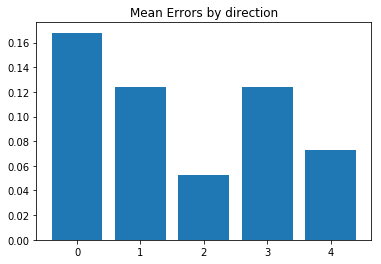

In [24]:
x = ['0','1','2','3','4']
plt.bar(x, height= [res_0/i_0, res_1/i_1, res_2/i_2, res_3/i_3, res_4/i_4])
plt.xticks(x, ['0','1','2','3','4']);
plt.title("Mean Errors by direction")

Text(0.5,1,'0 Errors')

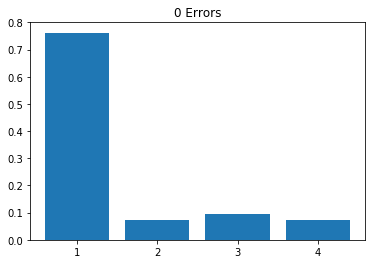

In [25]:
x = ['1','2','3','4']
plt.bar(x, height= [res_0_1/res_0, res_0_2/res_0, res_0_3/res_0, res_0_4/res_0])
plt.xticks(x, ['1','2','3','4']);
plt.title("0 Errors")

Text(0.5,1,'1 Errors')

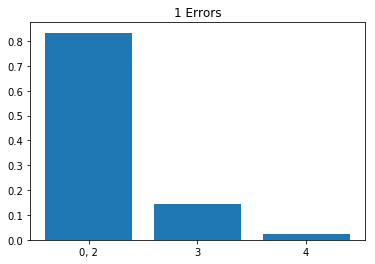

In [26]:
x = ['1','2','3']
plt.bar(x, height= [res_1_1/res_1, res_1_2/res_1, res_1_3/res_1])
plt.xticks(x, ['0, 2','3', '4']);
plt.title("1 Errors")

Text(0.5,1,'2 Errors')

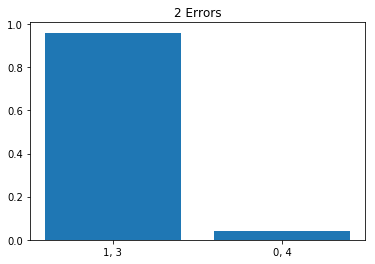

In [27]:
x = ['1','2']
plt.bar(x, height= [res_2_1/res_2, res_2_2/res_2])
plt.xticks(x, ['1, 3','0, 4']);
plt.title("2 Errors")

Text(0.5,1,'3 Errors')

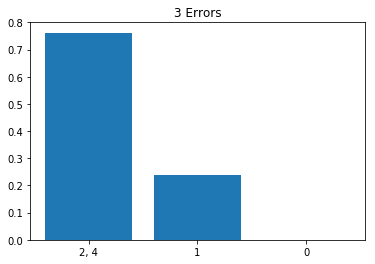

In [28]:
x = ['1','2','3']
plt.bar(x, height= [res_3_1/res_3, res_3_2/res_3, res_3_3/res_3])
plt.xticks(x, ['2, 4','1', '0']);
plt.title("3 Errors")

Text(0.5,1,'4 Errors')

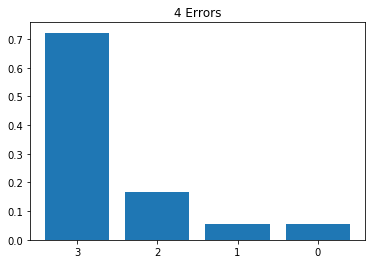

In [29]:
x = ['1','2','3','4']
plt.bar(x, height= [res_4_1/res_4, res_4_2/res_4, res_4_3/res_4, res_4_4/res_4])
plt.xticks(x, ['3','2','1','0']);
plt.title("4 Errors")